# Statistical Pattern Recognition - Solution 11: Sampling methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
import time
from matplotlib.patches import Ellipse
import scipy.stats
from timeit import default_timer as timer

# ensure that rerunning the notebook will give fixed results
np.random.seed(2701)

## Utility functions

In [2]:
def plot_gaussian(ax, mean, cov, color='red', size=3):
    # draws ellipses representing different standard deviations (size is the number of ellipses)
    # width and height are times by 2 since sqrt of the eigenval only measures half the distance
    eig_w, eig_v = np.linalg.eig(cov)
    # eigenvectors are orthogonal so we only need to check the first one
    eig_v_0 = eig_v[0]
    # arccos of first eigenvectors x coordinate will give us the angle
    angle = np.arccos(eig_v_0[0])
    # however, this only works for angles in [0, pi]
    # for angles in [pi, 2*pi] we need to consider the
    # y coordinate, too
    if eig_v_0[1] > 0:
        angle = 2 * np.pi - angle
    angle = np.rad2deg(angle)
    
    for i in range(size):
        ell = Ellipse(xy=[mean[0], mean[1]], 
                      width=np.sqrt(eig_w[0]) * 2 * (i + 1), 
                      height=np.sqrt(eig_w[1]) * 2 * (i + 1), 
                      angle=angle, 
                      edgecolor=color, lw=2, facecolor='none')
        ax.add_artist(ell)
    print(mean)
    ax.plot(mean[0], mean[1], "x", c=color, ms=20)


## $\star$ Part 1: Box-Muller method

Implement the Box-Muller method to produce $N$ samples from an isotropic Gaussian distribution of dimension $D$ with mean $\mu \in \mathbb{R}^D$  and covariance $\sigma^2 I \in \mathbb{R}^{D \times D}$ given a uniform proposal distribution. $I$ is the identity matrix. See [wikipedia](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) for the math. Use [np.random.uniform](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) for sampling the uniform distribution.

Hints:

* In a multivariate isotropic Gaussian the dimensions are independent of each other and can therefore be sampled independently.
* The Box-Muller method will give you a standard Gaussian distribution with mean 0 and standard deviation 1. Scale it by the standard deviation and add the mean to get an arbitrary Gaussian distribution.

Plot some samples and visualize the standard deviation with the utility function `plot_gaussian` above.

For comparison, plot samples with [scipy.stats.multivariate_normal.rvs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) and compare the results.


[10. 20.]


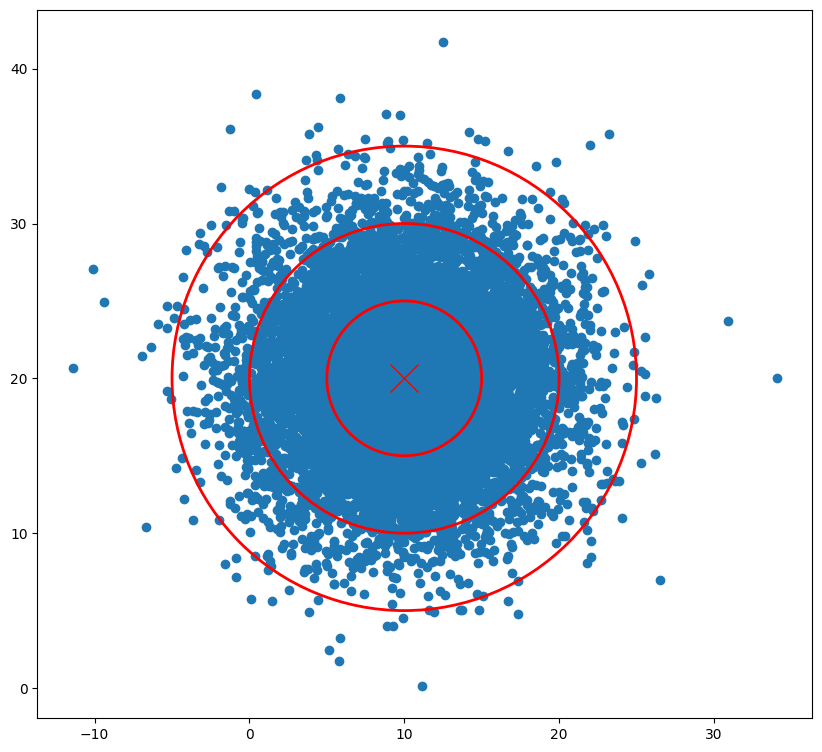

In [3]:
def box_muller(n_samples:int, dim:int, mean:np.ndarray, std:float):
    # START TODO ################
    requested_samples = n_samples * dim
    
    # since each box-muller step gives 2 samples, we only need to do
    # ceil(requested_samples / 2) steps to get enough samples.
    required_boxmuller_steps = np.ceil(requested_samples / 2).astype(int)
    
    # apply the method and concatenate the resulting samples
    u1 = np.random.uniform(size=required_boxmuller_steps)
    u2 = np.random.uniform(size=required_boxmuller_steps)
    r = np.sqrt(-2 * np.log(u1))
    theta = 2 * np.pi * u2
    x = r * np.cos(theta)  # shape (required_boxmuller_steps, )
    y = r * np.sin(theta)  # shape (required_boxmuller_steps, )
    samples = np.concatenate([x, y], axis=0)  # shape (required_boxmuller_steps * 2)
    
    # in case we need an uneven number of samples we have to discard the last one
    samples = samples[:requested_samples]
    
    # reshape to the target shape and rescale to fit the requested parameters
    samples = np.reshape(samples, [n_samples, dim])
    samples = samples * std + mean
    
    # END TODO ################
    return samples


# test function with 11 samples of a 3d gaussian 
gaussian_samples_3d = box_muller(11, 3, np.array([0., 0., 0.]), 1.)
assert gaussian_samples_3d.shape == (11, 3)

# define 2d gaussian
mean_2d = np.array([10., 20.])
std_2d = 5.
n = 10000

# START TODO ################
# sample and plot the samples
gaussian_samples_2d = box_muller(n, 2, mean_2d, std_2d)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.set_aspect("equal")
plt.scatter(gaussian_samples_2d[:, 0], gaussian_samples_2d[:, 1])
# END TODO ################

# START TODO ################
# plot the standard deviation ellipsis
cov_2d = std_2d ** 2 * np.eye(2)
plot_gaussian(ax, mean_2d, cov_2d)
# END TODO ################

plt.show()

[10. 20.]


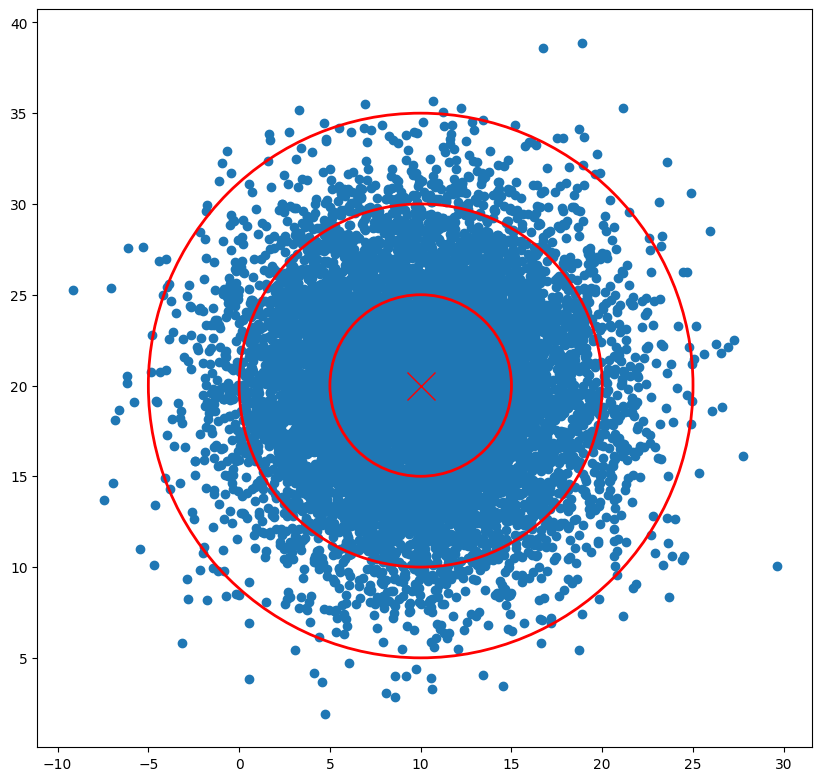

In [4]:
# START TODO ################
# sample and plot the same gaussian using scipy
gaussian_samples_2d = scipy.stats.multivariate_normal.rvs(mean_2d, cov_2d, size=n)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.set_aspect("equal")
plt.scatter(gaussian_samples_2d[:, 0], gaussian_samples_2d[:, 1])
plot_gaussian(ax, mean_2d, cov_2d)
plt.show()
# END TODO ################

## $\star$ $\star$ Part 2: Metropolis algorithm

Implement the Metropolis algorithm to sample from an anisotropic Gaussian distribution via an isotropic Gaussian proposal distribution. Use the box-muller method from above to sample from the proposal distribution.

Mean $\mu$ and covariance $\Sigma$ of the anisotropic Gaussian are given below (note that the covariance is and must be nonsingular). You can create an anisotropic gaussian object `scipy.stats.multivariate_normal` and then use its function `pdf(x)` to get the probability density at point `x`. Note that here the probability $p(x)$ is given, however for the Metropolis algorithm an unnormalized function $f(x) = p(x) / Z$ with an unknown normalization constant $Z$ would work as well. This is one of the advantages of the algorithm as $Z$ can be hard or impossible to compute depending on the distribution.

Choose the proposal distribution as $q(z|z^{(l)}) = \mathcal{N}(z^{(l)}, \sigma_q^2 I )$ and $q(z) = \mathcal{N}(\mu_q, \sigma_q^2 I)$ and set the hyperparameters as $\mu_q = \mu$, $\sigma_q = 0.1$.

Produce 10000 samples and plot them and the standard deviation ellipses. Note that you will need more trials than the number of samples since some samples will be discarded. You can safeguard against division by zero to avoid warnings.

Aside from comparing the samples of the distributions visually, compute the maximum-likelihood estimate of mean and covariance from the samples as in exercise 2 with `np.mean(samples, axis=0)` and `np.cov(samples.T)` and plot the standard deviation ellipses of your fit. You could then also evaluate the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Kullback%E2%80%93Leibler_divergence) between the original gaussian and the gaussian estimated from the samples.


In [4]:
mean = np.array([-1.26745097,  0.1375625 ])
cov = np.array([[3.10419125, 1.61656817], [1.61656817, 1.2180084 ]])

Found 10000 samples in 10643 trials after 0.807sec.
[-1.26745097  0.1375625 ]
[-0.35493643  0.60468029]
KL-Divergence D_kl(p || p_est): 0.3327191816885169


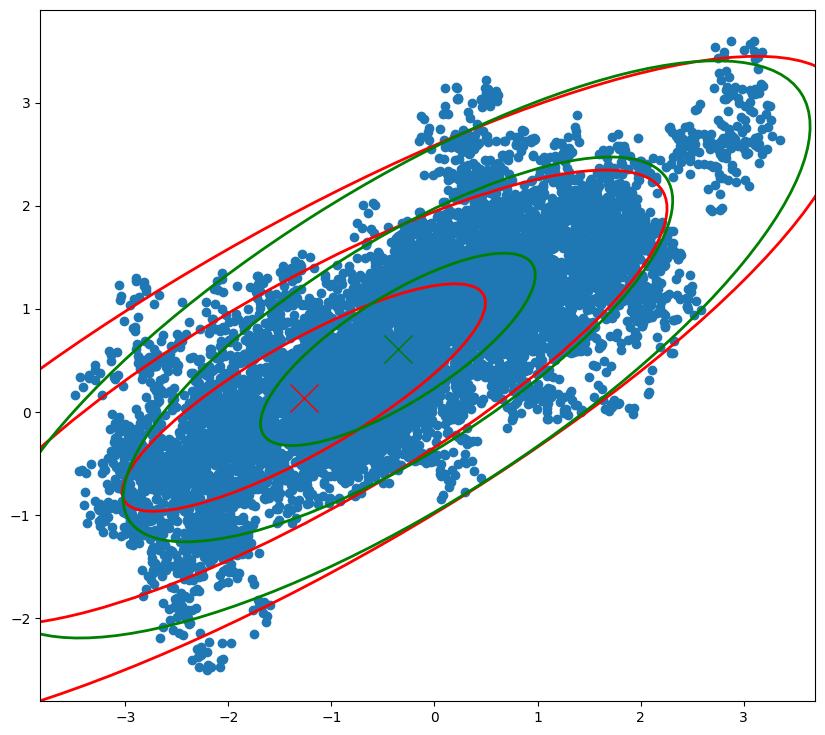

In [7]:
gaussian = scipy.stats.multivariate_normal(mean, cov)

def get_kldiv_of_gaussians(m0, c0, m1, c1):
    # START TODO ################
    # compute the KL divergence between two multivariate gaussians

    c1i = np.linalg.inv(c1)

    # expand difference of means to get a row vector
    md = (m1 - m0)[:, None]
    logdets = np.log(np.linalg.det(c1) / np.linalg.det(c0))
    kldiv = 0.5 * (np.trace( c1i @ c0  ) + md.T @ c1i @ md - len(m0) + logdets)
    
    # due to the expansion above the result needs to be squeezed again
    kldiv = np.squeeze(kldiv)
    # END TODO ################
    return kldiv

def compare_estimated_gaussian(ax, samples, orig_mean, orig_cov):
    # plot the estimated gaussian on the given axes and compare it to the original one

    # START TODO ################
    # estimate gaussian from samples
    est_mean = np.mean(samples, axis=0)
    est_cov = np.cov(samples.T)
    # END TODO ################
    
    # START TODO ################
    # plot standard deviation ellipses
    plot_gaussian(ax, est_mean, est_cov, color="green")
    # END TODO ################
    
    # START TODO ################
    # compute kl-divergence
    kl = get_kldiv_of_gaussians(orig_mean, orig_cov, est_mean, est_cov)
    # END TODO ################
    print(f"KL-Divergence D_kl(p || p_est): {kl}")
    

mean0 = mean # np.array([0, 0])
std = 0.1
n_samples = 10000
max_tries = 20000
dim = 2

t1 = timer()

# compute the random variables at once before
us = np.random.uniform(size=max_tries)
steps = box_muller(max_tries, dim, np.zeros(2), std)

# START TODO ################
# create the initial sample
z_init = mean0 + steps[0]
# END TODO ################

zs = []
# START TODO ################
# implement the Metropolis algorithm
for n in range(1, max_tries):
    # create the next sample
    z = z_init + steps[n]
    
    # compute the probability of acceptance
    prob = gaussian.pdf(z)
    prob_init = gaussian.pdf(z_init)
    
    if prob_init == 0:
        # for numerical reasons the probability in the denominator 
        # may go to zero and produce "division by zero" warnings.
        # here we avoid that.
        acceptance = 1
    else:
        # note that the min operator is not needed
        acceptance = prob / prob_init
    
    # accept or reject
    u = us[n]
    if acceptance > u:
        # keep the sample and set it as starting point for the next step
        z_init = z
        zs.append(z)
        if len(zs) >= n_samples:
            # algorithm is done
            break
# END TODO ################

print(f"Found {len(zs)} samples in {n} trials after {timer() - t1:.3f}sec.")
samples = np.array(zs)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.set_aspect("equal")
plt.scatter(samples[:, 0], samples[:, 1])
plot_gaussian(ax, mean, cov)
compare_estimated_gaussian(ax, samples, mean, cov)
plt.show()


Compare your results with directly sampling from the anisotropic Gaussian with its method `rvs`. What do you observe about the quality of the approximation? Can you improve it? Also, the master solution takes about 0.5 second to produce 10000 samples. Can you match this performance or even create a faster implementation?

[-1.26745097  0.1375625 ]
[-1.23485044  0.15501045]
KL-Divergence D_kl(p || p_est): 0.00025226028188309567


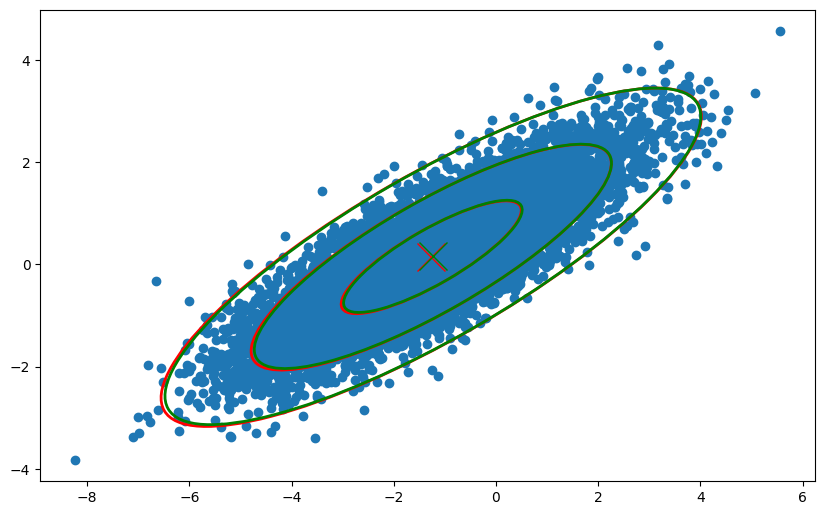

In [8]:
samples = gaussian.rvs(size=n_samples)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.set_aspect("equal")
plt.scatter(samples[:, 0], samples[:, 1])
plot_gaussian(ax, mean, cov)
compare_estimated_gaussian(ax, samples, mean, cov)
plt.show()

### Experiments to improve the algorithm

* To keep the samples from going too far away from the mean, restart the algorithm every `S` samples.
* Now it's possible to increase the standard deviation of the proposal distribution without the samples diverging too much.

Found 10000 samples in 11427 trials after 0.679sec.
[-1.26745097  0.1375625 ]
[-1.30007866  0.17351863]
KL-Divergence D_kl(p || p_est): 0.06793597668821083


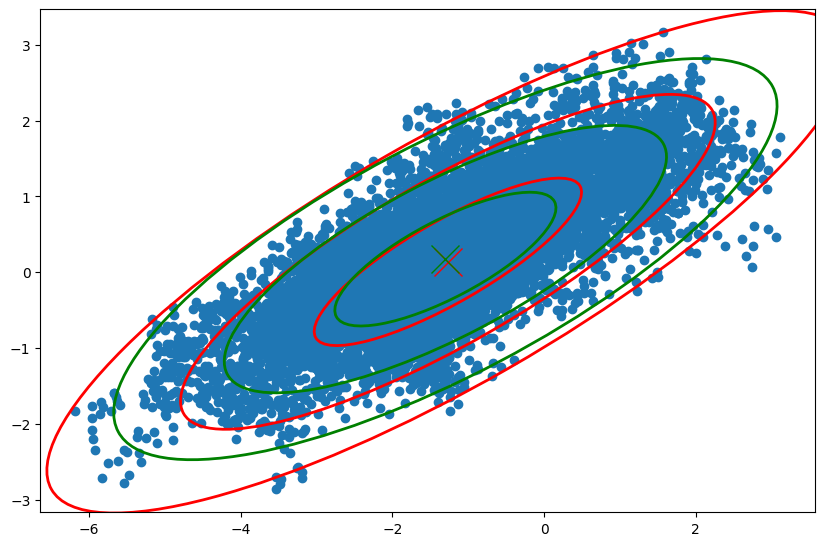

In [9]:
# START TODO ################
gaussian = scipy.stats.multivariate_normal(mean, cov)

mean0 = mean # np.array([0, 0])
std = 0.2
n_total_samples = 10000
n_samples = 250
max_tries = 2 * n_samples
runs = np.ceil(n_total_samples / n_samples).astype(int)
dim = 2

t1 = timer()

zs = []
n_trials = 0
for r in range(runs):
    zs_run = []
    # compute the random variables at once before
    us = np.random.uniform(size=max_tries)
    steps = box_muller(max_tries, dim, np.zeros(2), std)

    # create the initial sample
    z_init = mean0 + steps[0]
    for n in range(1, max_tries):
        n_trials += 1
        # create the next sample
        z = z_init + steps[n]

        # compute the probability of acceptance
        prob = gaussian.pdf(z)
        prob_init = gaussian.pdf(z_init)

        if prob_init == 0:
            # for numerical reasons the probability in the denominator 
            # may go to zero and produce "division by zero" warnings.
            # here we avoid that.
            acceptance = 1
        else:
            # note that the min operator is not needed
            acceptance = prob / prob_init

        # accept or reject
        u = us[n]
        if acceptance > u:
            # keep the sample and set it as starting point for the next step
            z_init = z
            zs_run.append(z)
            if len(zs_run) >= n_samples:
                # algorithm is done
                break
    zs += zs_run

print(f"Found {len(zs)} samples in {n_trials} trials after {timer() - t1:.3f}sec.")
samples = np.array(zs)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.set_aspect("equal")
plt.scatter(samples[:, 0], samples[:, 1])
plot_gaussian(ax, mean, cov)
compare_estimated_gaussian(ax, samples, mean, cov)
plt.show()
# END TODO ################